&#x202b;
# پروژه‌ی ۵ ام
## محمدرضا کیانی - ۸۱۰۱۹۴۳۸۸
&#x202b;
با توجه به این که سیستم من پردازنده‌ی گرافیکی اختصاصی نداشت، من این تمرین را روی کولب گوگل انجام دادم تا شبکه‌ی عصبی‌م را روی پردازنده‌های گرافیکی گوگل اجرا کنم. 


## 1
---
&#x202b;
در ابتدا من با مراجعه به
[صفحه‌ی آموزش pytorch برای داده‌ی CIFAR_10](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)
، با دستورات مورد نیاز را آشنا شدم و برای کاری که می‌خواستم انجام دهم آن‌ها را معادل سازی کردم.

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

&#x202b;
لود کردن داده‌های ترین و تست CIFAR_10

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:04, 41592866.32it/s]                               


Files already downloaded and verified


In [3]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train

In [4]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

&#x202b;
نمایش یک batch با اندازه‌ی ۳۲ تایی از داده‌ها به همراه لیبل آن‌ها جهت اطمینان از صحت آن‌ها

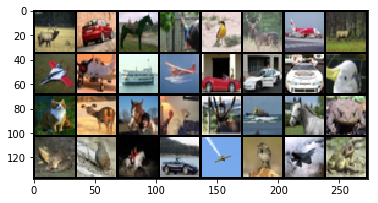

 deer   car horse  bird  bird  deer plane  deer
plane plane  ship plane   car   car   car  bird
  cat  deer horse   dog  deer  ship horse  frog
 frog  bird horse   car plane  bird plane  frog


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def group_imshow(images, labels, normal=False):
  # show images
  imshow(torchvision.utils.make_grid(images), normal)
  # print labels
  reshaped_label = labels.view(4, 8)
  for group in reshaped_label:
    print(' '.join('%5s' % classes[group[j]] for j in range(len(group))))  

def imshow(img, normal):
    if normal:
      img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

group_imshow(images, labels)

&#x202b;
مشخص کردن نوع دستگاهی که می‌تواند شبکه را اجرا کند

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda


&#x202b;
تعریف یک کلاس برای مشخص کردن ساختار شبکه‌ی عصبی

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, activation_function=F.relu):
        super(Net, self).__init__()
        self.factv = activation_function
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.factv(self.conv1(x))
        x = self.pool(self.factv(self.conv2(x)))
        x = x.view(-1, 16 * 12 * 12)
        x = self.factv(self.fc1(x))
        x = self.factv(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def print_weights(self):
      for param in self.parameters():
        print(param.data)

net = Net().to(device)

In [9]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

&#x202b;
صفر کردن تمام وزن‌ها و بایاس‌ها

In [0]:
def init_weights(m):
  if type(m) in [nn.Linear, nn.Conv2d]:
    torch.nn.init.zeros_(m.weight)
    torch.nn.init.zeros_(m.bias)


net.apply(init_weights)      
# net.print_weights()

&#x202b;
مشخص کردن تابع بهینه‌ساز و همچنین روش محاسبه‌ی خطا

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

&#x202b;
تابع برای آموزش شبکه در ۵ ایپاک (برخی از پارامترهای این تابع در بخش‌های بعدی پروژه نیاز است)

In [0]:
import datetime

def train_net(net, criterion, optimizer, return_loss=False, batch_size=32):
  start = datetime.datetime.now()
  log_counter = 10000 // batch_size
  loss_aggrigate = []
  for epoch in range(5):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          loss_aggrigate.append(loss.item())
          if i % log_counter == log_counter-1:    # print on each log counter
              print('[e:%d, b:%4d, d:%5d] loss: %.3f' %
                    (epoch + 1, (i + 1), (i + 1) * batch_size, running_loss / log_counter))
              running_loss = 0.0

  end = datetime.datetime.now()
  print('Finished Training After', end-start)
  if return_loss:
    return loss_aggrigate

&#x202b;
آموزش شبکه با وزن‌ها و بایاس‌های ۰

In [34]:
train_net(net, criterion, optimizer)

[e:1, b: 312, d: 9984] loss: 2.303
[e:1, b: 624, d:19968] loss: 2.303
[e:1, b: 936, d:29952] loss: 2.303
[e:1, b:1248, d:39936] loss: 2.303
[e:1, b:1560, d:49920] loss: 2.303
[e:2, b: 312, d: 9984] loss: 2.303
[e:2, b: 624, d:19968] loss: 2.303
[e:2, b: 936, d:29952] loss: 2.303
[e:2, b:1248, d:39936] loss: 2.303
[e:2, b:1560, d:49920] loss: 2.303
[e:3, b: 312, d: 9984] loss: 2.302
[e:3, b: 624, d:19968] loss: 2.303
[e:3, b: 936, d:29952] loss: 2.303
[e:3, b:1248, d:39936] loss: 2.303
[e:3, b:1560, d:49920] loss: 2.303
[e:4, b: 312, d: 9984] loss: 2.303
[e:4, b: 624, d:19968] loss: 2.303
[e:4, b: 936, d:29952] loss: 2.303
[e:4, b:1248, d:39936] loss: 2.303
[e:4, b:1560, d:49920] loss: 2.303
[e:5, b: 312, d: 9984] loss: 2.303
[e:5, b: 624, d:19968] loss: 2.303
[e:5, b: 936, d:29952] loss: 2.303
[e:5, b:1248, d:39936] loss: 2.303
[e:5, b:1560, d:49920] loss: 2.303
Finished Training After 0:00:44.557946


&#x202b;
تابع برای محاسبه‌ی دقت شبکه‌ی ترین شده بر روی داده‌ی تست

In [35]:
def accuracy_score(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return (100 * correct / total)

accuracy = accuracy_score(net)
print('Accuracy of the network on the 10000 test images: %d %%' % accuracy)

Accuracy of the network on the 10000 test images: 10 %


 (Confusion Matrix) تابع برای نمایش دقت شبکه روی هر گروه از داده‌ها  
 <br>
 &#x202b;
 جمع اعداد هر سطر برابر ۱ است و هر عدد در درایه‌ی i,j نشان دهنده‌ی پراکندگی پیشبینی ما (دسته‌ی j ام) برای دسته‌ی i ام است. 

In [0]:
def accuracy_score_by_class(net):
  total_correct = 0
  total_images = 0
  confusion_matrix = np.zeros([10,10], int)
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total_images += labels.size(0)
          total_correct += (predicted == labels).sum().item()
          for i, l in enumerate(labels):
              confusion_matrix[l.item(), predicted[i].item()] += 1 

  fig, ax = plt.subplots(1, 1, figsize=(8,6))
  ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
  for i in range(10):
      for j in range(10):
          ax.text(j, i, format(confusion_matrix[i, j]/1000, '.3f'),
                  ha="center", va="center",
                  color="black" if confusion_matrix[i, j]/1000 <= 0.3 else "white")
          
  plt.ylabel('Actual Category')
  plt.yticks(range(10), classes)
  plt.xlabel('Predicted Category')
  plt.xticks(range(10), classes)
  plt.show()

  for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * confusion_matrix[i, i] / confusion_matrix[i].sum()))

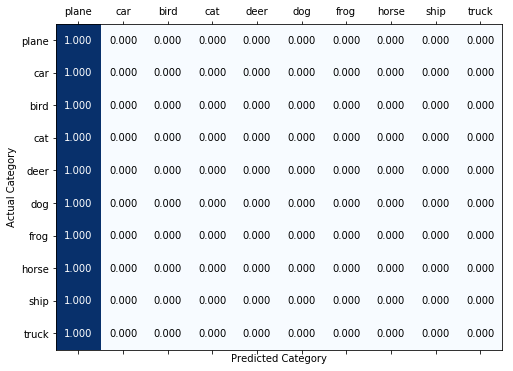

Accuracy of plane : 100 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


In [36]:
accuracy_score_by_class(net)

In [0]:
net.print_weights()

&#x202b;
اختصاص اعداد رندوم برای وزن لایه‌های مختلف شبکه

In [37]:
def randomize_weights(m):
  if type(m) in [nn.Linear, nn.Conv2d]:
    torch.nn.init.xavier_uniform_(m.weight)
    torch.nn.init.zeros_(m.bias)

net.apply(randomize_weights)      
# net.print_weights()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [39]:
train_net(net, criterion, optimizer)

[e:1, b: 312, d: 9984] loss: 2.142
[e:1, b: 624, d:19968] loss: 1.840
[e:1, b: 936, d:29952] loss: 1.676
[e:1, b:1248, d:39936] loss: 1.595
[e:1, b:1560, d:49920] loss: 1.571
[e:2, b: 312, d: 9984] loss: 1.490
[e:2, b: 624, d:19968] loss: 1.425
[e:2, b: 936, d:29952] loss: 1.402
[e:2, b:1248, d:39936] loss: 1.418
[e:2, b:1560, d:49920] loss: 1.382
[e:3, b: 312, d: 9984] loss: 1.262
[e:3, b: 624, d:19968] loss: 1.257
[e:3, b: 936, d:29952] loss: 1.250
[e:3, b:1248, d:39936] loss: 1.229
[e:3, b:1560, d:49920] loss: 1.206
[e:4, b: 312, d: 9984] loss: 1.098
[e:4, b: 624, d:19968] loss: 1.109
[e:4, b: 936, d:29952] loss: 1.108
[e:4, b:1248, d:39936] loss: 1.117
[e:4, b:1560, d:49920] loss: 1.109
[e:5, b: 312, d: 9984] loss: 0.968
[e:5, b: 624, d:19968] loss: 0.998
[e:5, b: 936, d:29952] loss: 0.991
[e:5, b:1248, d:39936] loss: 1.007
[e:5, b:1560, d:49920] loss: 1.029
Finished Training After 0:00:44.838416


In [40]:
accuracy = accuracy_score(net)
print('Accuracy of the network with random wieghts on the 10000 test images: %d %%' % accuracy)

Accuracy of the network with random wieghts on the 10000 test images: 60 %


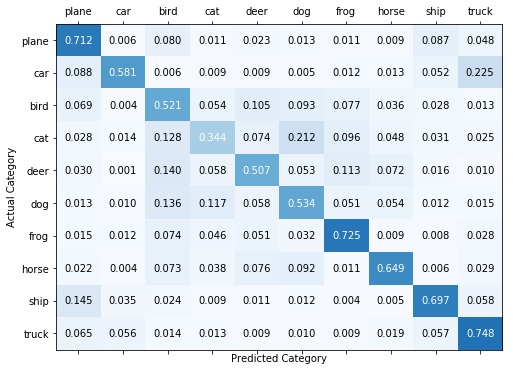

Accuracy of plane : 71 %
Accuracy of   car : 58 %
Accuracy of  bird : 52 %
Accuracy of   cat : 34 %
Accuracy of  deer : 50 %
Accuracy of   dog : 53 %
Accuracy of  frog : 72 %
Accuracy of horse : 64 %
Accuracy of  ship : 69 %
Accuracy of truck : 74 %


In [44]:
accuracy_score_by_class(net)

&#x202b;
در حالت وزن صفر، شبکه لرن نمی‌شود چرا که در back propagation وزن‌ها ۰ هست و برابری وزن‌ها سبب می‌شود که همه‌ی آن‌ها به یک اندازه تغییر کنند و این برای ما خوب نیست (در این جا نیز به اندازه‌ی ۰ همه‌ی وزن‌ها آپدیت می‌شوند) همچنین با این کار استقلال هر لایه‌ از ورودی‌ها ۰ خواهد اما با مقداردهی رندوم، مشکلات بالا را نداریم. 

## 2
---
&#x202b;
ابتدا یک شبکه‌ی عصبی دو لایه‌ای تعریف می‌کنم که اندازه‌ی کرنل و تعداد کانال‌های خروجی‌اش در کانستراکتور آن مشخص شود. سپس چندین نوع شبکه‌ی مختلف با پارامترهای گوناگون می‌سازم. 

In [0]:
class Net2Layer(nn.Module):
    def __init__(self, channel, kernel_size):
        super(Net2Layer, self).__init__()
        
        self.channel = channel
        self.kernel_size = kernel_size
        size = 32 - self.kernel_size + 1
        self.conv_out_size = self.channel * size * size

        self.conv = nn.Conv2d(3, self.channel, self.kernel_size)
        self.fc = nn.Linear(self.conv_out_size, 10)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = x.view(-1, self.conv_out_size)
        x = self.fc(x)
        return x

nets = []
nets.append(Net2Layer(channel=6, kernel_size=5).to(device))
nets.append(Net2Layer(channel=6, kernel_size=7).to(device))
nets.append(Net2Layer(channel=6, kernel_size=9).to(device))
nets.append(Net2Layer(channel=9, kernel_size=5).to(device))
nets.append(Net2Layer(channel=9, kernel_size=7).to(device))
nets.append(Net2Layer(channel=9, kernel_size=9).to(device))

&#x202b;
سپس این شبکه‌ها را با دیتای ترین، آموزش می‌دهم.

In [56]:
for net in nets:
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  print("taining for network with channel:", net.channel, ", kernel_size:", net.kernel_size)
  train_net(net, criterion, optimizer)

taining for network with channel: 6 , kernel_size: 5
[e:1, b: 312, d: 9984] loss: 2.082
[e:1, b: 624, d:19968] loss: 1.885
[e:1, b: 936, d:29952] loss: 1.798
[e:1, b:1248, d:39936] loss: 1.734
[e:1, b:1560, d:49920] loss: 1.680
[e:2, b: 312, d: 9984] loss: 1.607
[e:2, b: 624, d:19968] loss: 1.580
[e:2, b: 936, d:29952] loss: 1.555
[e:2, b:1248, d:39936] loss: 1.513
[e:2, b:1560, d:49920] loss: 1.481
[e:3, b: 312, d: 9984] loss: 1.478
[e:3, b: 624, d:19968] loss: 1.457
[e:3, b: 936, d:29952] loss: 1.475
[e:3, b:1248, d:39936] loss: 1.460
[e:3, b:1560, d:49920] loss: 1.474
[e:4, b: 312, d: 9984] loss: 1.413
[e:4, b: 624, d:19968] loss: 1.452
[e:4, b: 936, d:29952] loss: 1.444
[e:4, b:1248, d:39936] loss: 1.436
[e:4, b:1560, d:49920] loss: 1.442
[e:5, b: 312, d: 9984] loss: 1.416
[e:5, b: 624, d:19968] loss: 1.405
[e:5, b: 936, d:29952] loss: 1.417
[e:5, b:1248, d:39936] loss: 1.431
[e:5, b:1560, d:49920] loss: 1.436
Finished Training After 0:00:39.663273
taining for network with channel:

&#x202b;
دقت آن‌ها روی داده‌های تست را محاسبه و نتیجه را در نموداری نشان می‌دهم.

Accuracy of the network with random wieghts on the 10000 test images: 48 %
Accuracy of the network with random wieghts on the 10000 test images: 49 %
Accuracy of the network with random wieghts on the 10000 test images: 48 %
Accuracy of the network with random wieghts on the 10000 test images: 51 %
Accuracy of the network with random wieghts on the 10000 test images: 49 %
Accuracy of the network with random wieghts on the 10000 test images: 49 %


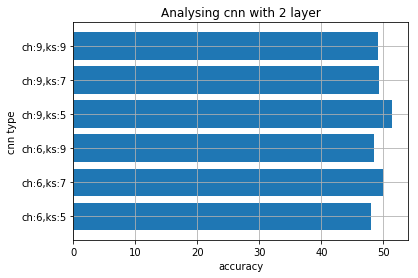

In [57]:
accuracy = []
for net in nets:
  accuracy.append(accuracy_score(net))
  print('Accuracy of the network with random wieghts on the 10000 test images: %d %%' % accuracy[-1])
  
labels = ["ch:{},ks:{}".format(net.channel, net.kernel_size) for net in nets]
axis = range(len(nets))

plt.barh(axis, accuracy, align='center')
plt.yticks(axis, labels)
plt.xlabel("accuracy")
plt.ylabel("cnn type")
plt.title('Analysing cnn with 2 layer')
plt.grid()
plt.show()

&#x202b;
با این مشاهده شبکه‌ی عصبی با لایه‌ی میانی کانولوشن که خروجی آن ۹ کانال و کرنل سایز آن ۵ است را انتخاب می‌کنم.
<br>
&#x202b;
نتیجه‌ی کلی: لایه‌ی اول یک لایه‌ی کانولوشن با ورودی ۳ و خروجی ۹ کانال و کرنل سایز ۵ - لایه‌ی دوم یک لایه‌ی خطی با ورودی ۲۸ * ۲۸ * ۹ کانال و خروجی ۱۰ کاناله 

 ## 3
 ---
 &#x202b;
ابتدا یک عملیات برای تغییر شکل داده‌ها اضافه می‌کنم که میانگین و واریانس را نرمال کند.

In [45]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


&#x202b;
مشاهده‌ی داده‌های نرمال شده

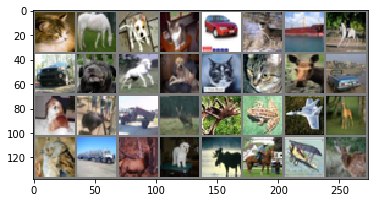

  cat horse   dog   cat   car  deer  ship horse
  car   dog horse   dog   cat   cat  deer   car
  dog  bird truck  deer  deer  frog plane   dog
 bird truck  deer   dog  deer horse plane  deer


In [46]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

group_imshow(images, labels, normal=True)

In [0]:
net = Net().to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [49]:
train_net(net, criterion, optimizer)

[e:1, b: 312, d: 9984] loss: 2.049
[e:1, b: 624, d:19968] loss: 1.683
[e:1, b: 936, d:29952] loss: 1.532
[e:1, b:1248, d:39936] loss: 1.474
[e:1, b:1560, d:49920] loss: 1.399
[e:2, b: 312, d: 9984] loss: 1.304
[e:2, b: 624, d:19968] loss: 1.267
[e:2, b: 936, d:29952] loss: 1.244
[e:2, b:1248, d:39936] loss: 1.215
[e:2, b:1560, d:49920] loss: 1.171
[e:3, b: 312, d: 9984] loss: 1.070
[e:3, b: 624, d:19968] loss: 1.057
[e:3, b: 936, d:29952] loss: 1.082
[e:3, b:1248, d:39936] loss: 1.107
[e:3, b:1560, d:49920] loss: 1.057
[e:4, b: 312, d: 9984] loss: 0.921
[e:4, b: 624, d:19968] loss: 0.942
[e:4, b: 936, d:29952] loss: 0.966
[e:4, b:1248, d:39936] loss: 0.952
[e:4, b:1560, d:49920] loss: 0.959
[e:5, b: 312, d: 9984] loss: 0.772
[e:5, b: 624, d:19968] loss: 0.844
[e:5, b: 936, d:29952] loss: 0.855
[e:5, b:1248, d:39936] loss: 0.871
[e:5, b:1560, d:49920] loss: 0.884
Finished Training After 0:00:52.333504


In [50]:
accuracy = accuracy_score(net)
print('Accuracy of the network with normalized data on the 10000 test images: %d %%' % accuracy)

Accuracy of the network with normalized data on the 10000 test images: 63 %


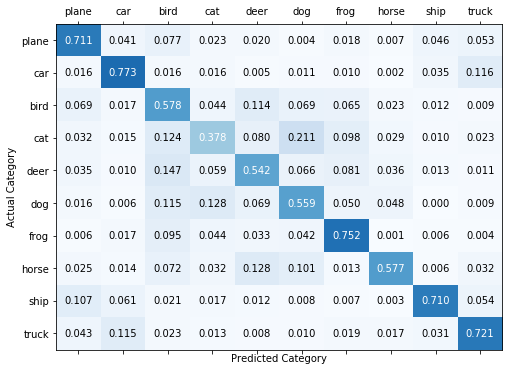

Accuracy of plane : 71 %
Accuracy of   car : 77 %
Accuracy of  bird : 57 %
Accuracy of   cat : 37 %
Accuracy of  deer : 54 %
Accuracy of   dog : 55 %
Accuracy of  frog : 75 %
Accuracy of horse : 57 %
Accuracy of  ship : 71 %
Accuracy of truck : 72 %


In [51]:
accuracy_score_by_class(net)

&#x202b;
در انتها مشاهده می‌شود که با نرمالیزیشن دقت بهتر شده و از ۶۰٪ به ۶۳٪ رسید ولی سرعت یادگیری کاهش یافته و زمان بیشتری باید برای یادگیری شبکه منتظر بمانیم. یعنی زمان یادگیری از ۴۴ ثانیه به ۵۲ ثانیه افزایش یافت.

&#x202b;
همچنین همان‌طور که در صورت این بخش نیز گفته شده، نرمالیزیشن باید مستقل از label های داده‌ها انجام بشود چرا که نرمالیزیشن یک روش برای آماده‌سازی بهتر داده‌ها برای ورود به شبکه است و اگر برچسب‌ها بخواهند در آن قسمت نیز تاثیر گذار باشند، ممکن است به مشکلاتی از جمله اورفیت شدن یا بایاس شدن شبکه نسبت به یک نوع ورودی خاص مواجه شویم.

## 4
---
&#x202b;
در این بخش من ابتدا به کمک یک نرخ یادگیری بزرگ (۱) و سپس نرخ یادگیری معقول (۰.۰۱) و در نهایت با ۱/۱۰۰ آن (۰.۰۰۰۱) به بررسی شبکه‌های عصبی پرداختم و خطای هر یک از آن‌ها را در هر مرحله‌ از یادگیری ذخیره کردم.

In [66]:
learning_rates = [1, 0.01, 0.0001]
losses = []
for learning_rate in learning_rates:
  net = Net().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
  print('start training for cnn with learning rate:', learning_rate)
  losses.append(train_net(net, criterion, optimizer, return_loss=True))

start training for cnn with learning rate: 1
[e:1, b: 312, d: 9984] loss: 2.381
[e:1, b: 624, d:19968] loss: 2.380
[e:1, b: 936, d:29952] loss: 2.379
[e:1, b:1248, d:39936] loss: 2.373
[e:1, b:1560, d:49920] loss: 2.380
[e:2, b: 312, d: 9984] loss: 2.375
[e:2, b: 624, d:19968] loss: 2.372
[e:2, b: 936, d:29952] loss: 2.378
[e:2, b:1248, d:39936] loss: 2.375
[e:2, b:1560, d:49920] loss: 2.370
[e:3, b: 312, d: 9984] loss: 2.369
[e:3, b: 624, d:19968] loss: 2.381
[e:3, b: 936, d:29952] loss: 2.372
[e:3, b:1248, d:39936] loss: 2.365
[e:3, b:1560, d:49920] loss: 2.375
[e:4, b: 312, d: 9984] loss: 2.378
[e:4, b: 624, d:19968] loss: 2.378
[e:4, b: 936, d:29952] loss: 2.379
[e:4, b:1248, d:39936] loss: 2.377
[e:4, b:1560, d:49920] loss: 2.378
[e:5, b: 312, d: 9984] loss: 2.376
[e:5, b: 624, d:19968] loss: 2.391
[e:5, b: 936, d:29952] loss: 2.380
[e:5, b:1248, d:39936] loss: 2.380
[e:5, b:1560, d:49920] loss: 2.388
Finished Training After 0:00:58.402061
start training for cnn with learning rate

&#x202b;
نمایش روند تغییر خطا در هر قدم در شبکه‌های با نرخ یادگیری متفاوت

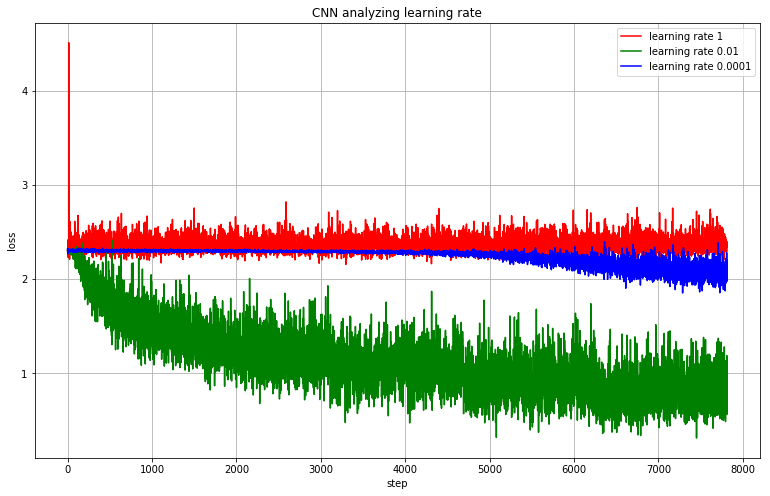

In [67]:
x_range = range(len(losses[0]))
colors = ['red', 'green', 'blue']

plt.figure(figsize=(13,8))
for i, learning_rate in enumerate(learning_rates):
  plt.plot(x_range, losses[i], '-r', label='learning rate {}'.format(learning_rate), c=colors[i])
plt.xlabel('step')
plt.ylabel('loss')
plt.title('CNN analyzing learning rate')
plt.grid()
plt.legend()
plt.show()

&#x202b;
نَرم‌تر کردن نمودار با اگریگیت کردن هر ۲۰ داده با هم

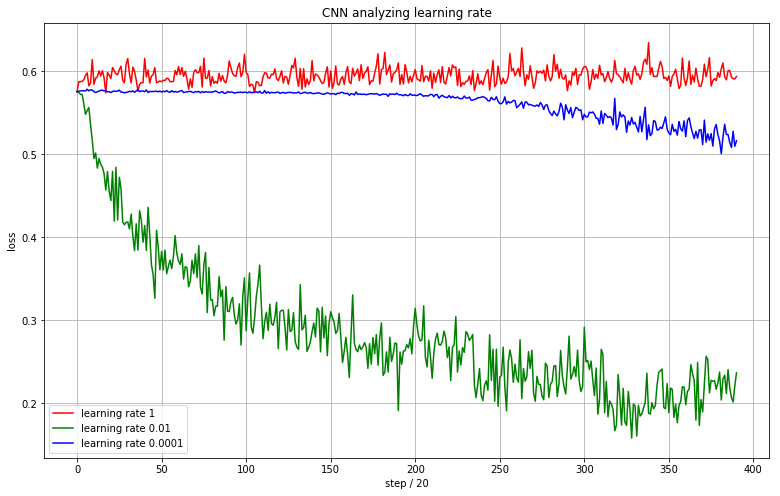

In [68]:
def soft_loss(loss, soft_limit):
  sloss = []
  for i in range(0, len(loss), soft_limit):
    sloss.append(sum(loss[i:i+5]) / soft_limit)
  return sloss

soft_limit = 20
slosses = []
for loss in losses:
  slosses.append(soft_loss(loss, soft_limit))

x_range = range(len(slosses[0]))
colors = ['red', 'green', 'blue']

plt.figure(figsize=(13,8))
for i, learning_rate in enumerate(learning_rates):
  plt.plot(x_range, slosses[i], '-r', label='learning rate {}'.format(learning_rate), c=colors[i])
plt.xlabel('step / {}'.format(soft_limit))
plt.ylabel('loss')
plt.title('CNN analyzing learning rate')
plt.grid()
plt.legend()
plt.show()

&#x202b;
هنگامی که نرخ یادگیری عدد بزرگی باشد، خطا در هر مرحله ممکن است بسیار تغییر کند و جهش‌ها و ناپایداری‌هایی در بخش یادگیری داشته باشیم و در نهایت به نقطه‌ی بهینه نرسیم (یا دیرتر برسیم) اما هنگامی که با یک نرخ یادگیری معقول حرکت می‌کنیم، خطا  دارای نرخی نزولی می‌شود و به طور کلی کاهش می‌یابد. در نرخ‌های یادگیری بسیار کوچک، یادگیری بسیار کند می‌شود و پردازش همان حجم از مراحل روی داده‌ها، سبب تغییری کوچک‌تر و حرکتی اندک‌تر در جهت بهبودی شبکه نسبت به حالت با نرخ‌ یادگیری معقول می‌شود و برای رسیدن به دقت مناسب، باید تعداد مراحل یادگیری را افزایش دهیم.

### 5
---
&#x202b;
برای batch size های ۳۲ و ۶۴ و ۲۵۶ دقت را اندازه گیری می‌کنم.

In [69]:
batch_sizes = [32, 64, 256]
learning_rates = [0.01, 0.001, 0.00001]

for i, batch_size in enumerate(batch_sizes):
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
  
  net = Net().to(device)
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=learning_rates[i], momentum=0.9)
  
  print('Start training network with batch_size: %d, lr: %1.5f' % (batch_size, learning_rates[i]))
  train_net(net, criterion, optimizer, batch_size=batch_size)
  accuracy = accuracy_score(net)
  print('Accuracy of the network on the 10000 test images: %d %%' % (accuracy))


Start training network with batch_size: 32, lr: 0.01000
[e:1, b: 312, d: 9984] loss: 2.065
[e:1, b: 624, d:19968] loss: 1.672
[e:1, b: 936, d:29952] loss: 1.555
[e:1, b:1248, d:39936] loss: 1.480
[e:1, b:1560, d:49920] loss: 1.388
[e:2, b: 312, d: 9984] loss: 1.319
[e:2, b: 624, d:19968] loss: 1.294
[e:2, b: 936, d:29952] loss: 1.239
[e:2, b:1248, d:39936] loss: 1.227
[e:2, b:1560, d:49920] loss: 1.184
[e:3, b: 312, d: 9984] loss: 1.091
[e:3, b: 624, d:19968] loss: 1.082
[e:3, b: 936, d:29952] loss: 1.079
[e:3, b:1248, d:39936] loss: 1.090
[e:3, b:1560, d:49920] loss: 1.067
[e:4, b: 312, d: 9984] loss: 0.914
[e:4, b: 624, d:19968] loss: 0.937
[e:4, b: 936, d:29952] loss: 0.960
[e:4, b:1248, d:39936] loss: 0.967
[e:4, b:1560, d:49920] loss: 0.984
[e:5, b: 312, d: 9984] loss: 0.791
[e:5, b: 624, d:19968] loss: 0.841
[e:5, b: 936, d:29952] loss: 0.867
[e:5, b:1248, d:39936] loss: 0.852
[e:5, b:1560, d:49920] loss: 0.874
Finished Training After 0:00:58.857051
Accuracy of the network on the

&#x202b;
در ابتدا برداشت من این بود که با توجه به این که با زیاد شدن batch size دقت محاسبه‌ی گرادیان بیشتر می‌شود، می‌توان قدم‌ها را سریع‌تر برداشت و نرخ یادگیری را افزایش داد و امیدوار بود که با هم خوب کار کنند. من با همین فرض ابتدا نرخ‌های یادگیری را افزایش دادم اما متوجه شدم که نرخ تغییرات خطا در هر مرحله کاهشی نیست و به دقت مناسبی نمی‌رسیدم. در ادامه نرخ یادگیری را نیز کاهش دادم که سبب کاهشی شدن نرخ تغییرات خطا در هر مرحله شد.<br>
&#x202b;
پس از کمی جستجو و تفکر متوجه شدم که مقدار بازگردانده‌شده  توسط بهینه‌ساز  SGD، مجموع گرادیان بچ دریافتی است و میانگین را به ما نمی‌دهد. آپدیت وزن‌ها نیز از جمع وزن قبلی با گرادیان به دست آمده * نرخ یادگیری به دست می‌آید. بنابراین باید نرخ یادگیری کاهش پیدا کند تا حاصل ضرب مجموع گرادیان در نرخ یادگیری، مقدار خیلی زیادی نباشد. راه دیگر استفاده از یک نرخ یادگیری ثابت و اضافه کردن یک ثابت میانگین برای تقسیم این حاصل به دست آمده است که باعث مستق شدن نرخ یادگیری از اندازه‌ی batch می‌شود.
 <br>
&#x202b;
 بنابر این رابطه‌ی batch size و learning rate معکوس است بدین معنی که با افزایش batch size ، نرخ یادگیری باید کاهش بیابد.

---
&#x202b;
batch size در واقع باعث می‌شود دقت گرادیان حساب شده در روش SGD، بر اساس تنها یک داده نباشد و احتمال خطا را پایین می‌آورد. همچنین با استفاده از آن سرعت یادگیری شبکه نیز بیشتر شده و قدم‌های کمتری در هر ایپاک باید برداریم. در صورتی که batch size بزرگ باشد، می‌تواند محاسبات سنگین‌تری برای به دست آوردن گرادیان داشته باشد اما از نتیجه‌ی به دست آمده در هر حرکت می‌توان مطمئن‌تر بود. اگر batch size خیلی بزرگ شود دیگر تفاوتی با روش GD ندارد و باز ما با مشکل سرعت بسیار پایین یادگیری و قدم برداشتن مواجه می‌شویم. در واقع این سرعت پایین یک باتل‌نک است که برای حل آن حاضر هستیم کمی دقت محاسبه‌ی گرادیان را کم کنیم ولی در عوض قدم‌های بیشتری برداریم.<br>



## 6
---
&#x202b;
با توجه به تغییر اندازه‌ی  batch در قسمت قبلی، دوباره اندازه‌ی batch را به ۳۲ باز می‌گردانم

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

&#x202b;
حال برای توابع فعال سازی خواسته شده زمان و دقت‌شان را به دست می‌آورم تا در ادامه آن‌ها را تحلیل کنم.

In [71]:
factv = {'relu': F.relu, 'leaky_relu': F.leaky_relu, 'tanh': torch.tanh, 'softplus': F.softplus}
accuracy = []
times = []
for key, actv in factv.items():
  start = datetime.datetime.now()
  
  net = Net(activation_function=actv).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
  
  print('Start training for network with activation function', key)
  train_net(net, criterion, optimizer)
  
  accuracy.append(accuracy_score(net))
  print('Accuracy:', accuracy[-1])
  
  end = datetime.datetime.now()
  times.append(end - start)

Start training for network with activation function relu
[e:1, b: 312, d: 9984] loss: 2.087
[e:1, b: 624, d:19968] loss: 1.729
[e:1, b: 936, d:29952] loss: 1.563
[e:1, b:1248, d:39936] loss: 1.482
[e:1, b:1560, d:49920] loss: 1.426
[e:2, b: 312, d: 9984] loss: 1.300
[e:2, b: 624, d:19968] loss: 1.272
[e:2, b: 936, d:29952] loss: 1.235
[e:2, b:1248, d:39936] loss: 1.199
[e:2, b:1560, d:49920] loss: 1.198
[e:3, b: 312, d: 9984] loss: 1.044
[e:3, b: 624, d:19968] loss: 1.068
[e:3, b: 936, d:29952] loss: 1.075
[e:3, b:1248, d:39936] loss: 1.059
[e:3, b:1560, d:49920] loss: 1.056
[e:4, b: 312, d: 9984] loss: 0.909
[e:4, b: 624, d:19968] loss: 0.922
[e:4, b: 936, d:29952] loss: 0.956
[e:4, b:1248, d:39936] loss: 0.951
[e:4, b:1560, d:49920] loss: 0.951
[e:5, b: 312, d: 9984] loss: 0.763
[e:5, b: 624, d:19968] loss: 0.813
[e:5, b: 936, d:29952] loss: 0.839
[e:5, b:1248, d:39936] loss: 0.852
[e:5, b:1560, d:49920] loss: 0.863
Finished Training After 0:00:56.916135
Accuracy: 63.51
Start trainin

&#x202b;
مشاهده‌ی نموار دقت به ازای توابع فعال سازی مختلف که تابع leaky_relu بالاترین دقت را دارد.

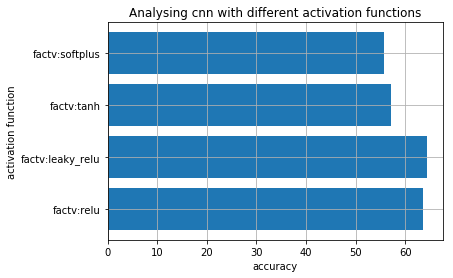

In [72]:
labels = ["factv:{}".format(key) for key in factv]
axis = range(len(factv))

plt.barh(axis, accuracy, align='center')
plt.yticks(axis, labels)
plt.xlabel("accuracy")
plt.ylabel("activation function")
plt.title('Analysing cnn with different activation functions')
plt.grid()
plt.show()

&#x202b;
مشاهده‌ی نموار زمان اجرا به ازای توابع فعال سازی مختلف که تفاوت محسوسی با هم ندارند.

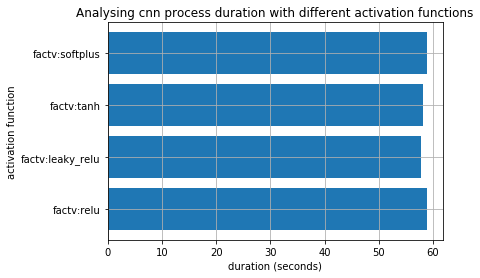

In [73]:
durations = list(map(lambda time: time.total_seconds(), times))
labels = ["factv:{}".format(key) for key in factv]
axis = range(len(factv))

plt.barh(axis, durations, align='center')
plt.yticks(axis, labels)
plt.xlabel("duration (seconds)")
plt.ylabel("activation function")
plt.title('Analysing cnn process duration with different activation functions')
plt.grid()
plt.show()

&#x202b;
در نتیجه تابع فعالسازی leaky_relu  بیشترین دقت را روی داده‌ی تست داشت و می‌تواند انتخاب بهتری باشد.

## 7
---
&#x202b;
در این بخش من ابتدا دو شبکه‌ی یکسان را با مقدار ۰ و ۰.۹ momentum آموزش می‌دهم تا در ادامه نتایج آن را مشاهده کنیم.


In [77]:
momentums = [0.0, 0.9]
accuracy = []
times = []
for momentum in momentums:
  start = datetime.datetime.now()
  
  net = Net(activation_function=F.leaky_relu).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=momentum)
  
  print('Start training for network with SGD momentum', momentum)
  train_net(net, criterion, optimizer)
  
  accuracy.append(accuracy_score(net))
  print('Accuracy:', accuracy[-1])
  
  end = datetime.datetime.now()
  times.append(end - start)

Start training for network with SGD momentum 0.0
[e:1, b: 312, d: 9984] loss: 2.303
[e:1, b: 624, d:19968] loss: 2.298
[e:1, b: 936, d:29952] loss: 2.270
[e:1, b:1248, d:39936] loss: 2.108
[e:1, b:1560, d:49920] loss: 1.981
[e:2, b: 312, d: 9984] loss: 1.893
[e:2, b: 624, d:19968] loss: 1.824
[e:2, b: 936, d:29952] loss: 1.755
[e:2, b:1248, d:39936] loss: 1.714
[e:2, b:1560, d:49920] loss: 1.676
[e:3, b: 312, d: 9984] loss: 1.635
[e:3, b: 624, d:19968] loss: 1.601
[e:3, b: 936, d:29952] loss: 1.568
[e:3, b:1248, d:39936] loss: 1.540
[e:3, b:1560, d:49920] loss: 1.503
[e:4, b: 312, d: 9984] loss: 1.474
[e:4, b: 624, d:19968] loss: 1.448
[e:4, b: 936, d:29952] loss: 1.430
[e:4, b:1248, d:39936] loss: 1.405
[e:4, b:1560, d:49920] loss: 1.403
[e:5, b: 312, d: 9984] loss: 1.352
[e:5, b: 624, d:19968] loss: 1.320
[e:5, b: 936, d:29952] loss: 1.319
[e:5, b:1248, d:39936] loss: 1.319
[e:5, b:1560, d:49920] loss: 1.314
Finished Training After 0:00:53.713177
Accuracy: 51.57
Start training for ne

&#x202b;
نمودار دقت بر اساس مقادیر مختلف momentum

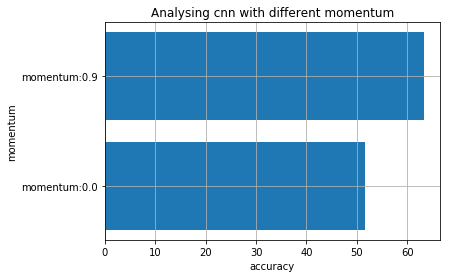

In [78]:
labels = ["momentum:{}".format(momentum) for momentum in momentums]
axis = range(len(momentums))

plt.barh(axis, accuracy, align='center')
plt.yticks(axis, labels)
plt.xlabel("accuracy")
plt.ylabel("momentum")
plt.title('Analysing cnn with different momentum')
plt.grid()
plt.show()

&#x202b;
نمودار زمان به ازای مقادیر مختلف momentum

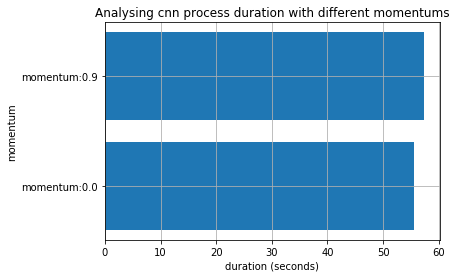

In [79]:
durations = list(map(lambda time: time.total_seconds(), times))
labels = ["momentum:{}".format(momentum) for momentum in momentums]
axis = range(len(momentums))

plt.barh(axis, durations, align='center')
plt.yticks(axis, labels)
plt.xlabel("duration (seconds)")
plt.ylabel("momentum")
plt.title('Analysing cnn process duration with different momentums')
plt.grid()
plt.show()

&#x202b;
طبق نتیجه‌ی به دست آمده وقتی ما momentum بالایی مثل ۰.۹ داریم، دقت بالاتر و زمان اجرای بیشتری نسبت به زمانی داریم که momentum ما ۰ می‌باشد. <br>
&#x202b;
علت آن است که momentum تاثیر وزن هر لایه در step قبلی در محاسبه‌ی وزن‌های جدید است و باعث می‌شود که ما در مینیموم محلی نیفتیم چرا که جهت حرکت گرادیان با در نظر گرفتن ضریبی از محاسبات قبلی تقریبا در همان جهت باقی می‌ماند در نتیجه باعث افزایش قدم‌ها به سمت نقطه‌ی مینیموم می‌شود و کمتر ممکن است در یک نقطه‌ی مینیموم نسبی گیر کند. این بخش محاسبات اضافه‌ای را به شبکه اضافه می‌کند که سبب طولانی‌تر شدن زمان یادگیری در هر مرحله می‌شود اما در محموع دقت ما را بهتر می‌کند و باعث می‌شود نسبت به حالت با momentum صفر، سریع‌تر به دقت بهتر برسیم. در واقع اگر ما می‌خواستیم زمان لازم مثلا برای رسیدن به دقت ۵۰٪ را به دست بیاوریم، در momentum بالاتر این اتفاق زودتر پیش می‌آمد.

&#x202b;
خروجی html گرفتن از فایل ژوپیتر

In [52]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [54]:
!jupyter nbconvert --to html gdrive/My\ Drive/Colab\ Notebooks/AI_CA5_CIFAR_10_CNN.ipynb

[NbConvertApp] Converting notebook gdrive/My Drive/Colab Notebooks/AI_CA5_CIFAR_10_CNN.ipynb to html
[NbConvertApp] Writing 1077503 bytes to gdrive/My Drive/Colab Notebooks/AI_CA5_CIFAR_10_CNN.html
